In [1]:
from fastai.vision import *
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import optim
# from torchsummary import summary
import gc
import fastai


import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import copy

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler 
from torch.autograd import Variable


import loader
import time 
from collections import OrderedDict
import pdb

from ranger import Ranger

# use gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# from fastai import callbacks
from fastai.callback import *
import fastai.test_utils

from fastai.learner import Learner

# from fastai.test_utils import *
# from fastai.test_utils import hook_outputs

# from fastai.utils.mem import *

In [2]:
from fastai.callback import hook

In [3]:
hook.hook_outputs

<function fastai.callback.hook.hook_outputs(modules, detach=True, cpu=False, grad=False)>

# Loading data/dataloaders

In [4]:
class Img_Dataset(Dataset):
    def __init__(self, data_set, patch_size, width, height, seed=1234):
        """
        Parameters:
        -----------
        data: np.ndarray
            Array that contains image/label pairs ie. corrupted image/clean image.
            Shape = (P, N, C, H, W):
                P = corrupted/uncorrupted image pair 
                N = number of samples
                C = number of channels
                H = image height
                W = image width
        patch_size: int
            Size of randomly chosen image patch the model uses for training
        width: int
            Width of the chosen sample.
            NOTE: It's a parameter because you can input a larger image and choose
                  to look at only portions of said image for more training samples.
        height: int
            Height of the chosen sample.
        seed: int 
            Randomized seed used for the random slicing used to create the image patch.
        """
        self.data_set = data_set
        self.patch_size = patch_size
        self.width = width
        self.height = height
        self.seed = seed

    def __len__(self):
        return len(self.data_set[0])

    def __getitem__(self, idx):
        """
        Function that returns the PyTorch Dataloader compatible dataset.
        
        Parameters:
        -----------
        idx: var
            Variable used in PyTorch Dataloader to be able to sample from the dataset
            to create minibatches of the data for us automatically.
        """
        # Loading the dataset and then slicing the image/label pairs 
        # ie. corrupted/uncorrupted images. 
        # Note the use of the idx in the image/label variables. This allows the
        # PyTorch Dataloader to get all the important data info eg. (N, C, H, W)
        data = self.data_set
        image = data[0, idx]
        label = data[1, idx]
        
        # Setting the patch size and the randomized seed for the image patch
        patch_size = self.patch_size
        seed = self.seed
        rng = np.random.RandomState(seed)

        img_width = self.width
        img_height = self.height
        
        #randomly crop patch from training set
        x1 = rng.randint(img_width - patch_size)
        y1 = rng.randint(img_height - patch_size)
        S = (slice(y1, y1 + patch_size), slice(x1, x1 + patch_size))
        
        # create new arrays for training patchs
        image_patch = image[0][S]
        label_patch = label[0][S]
        

        image_patch = image_patch[np.newaxis, :, :]
        label_patch = label_patch[np.newaxis, :, :]
        
        image_patch = np.concatenate((image_patch,)*3, axis=0)
        label_patch = np.concatenate((label_patch,)*3, axis=0)

        
        # Turning our image/label to a PyTorch Tensor with dtype = float 
        # and then putting it onto the GPU for faster training/inference
        image = torch.from_numpy(image_patch).float().to(device)
        label = torch.from_numpy(label_patch).float().to(device)
            
        return image, label

In [5]:
#Load the actual data that we're working on & print the shape of this data
train_data = loader.load('training_data610-2000.npy')
test_data = loader.load('test_data200-2000.npy')
print('Shape of train set=', train_data.shape)

Shape of train set= (2, 610, 1, 2000, 2000)


In [6]:
train_ds = Img_Dataset(data_set=train_data,
                       patch_size=64,
                       height=2000,
                       width=2000)

test_ds = Img_Dataset(data_set=test_data,
                       patch_size=64,
                       height=2000,
                       width=2000)

In [7]:
train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=56, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([56, 3, 64, 64])
Labels batch shape: torch.Size([56, 3, 64, 64])


In [8]:
# pre-trained VGG16 (with  batch norm) for feature loss
from torchvision.models import vgg16_bn


In [9]:
bs=8 #batch size
size=2000 # image size (size x size)

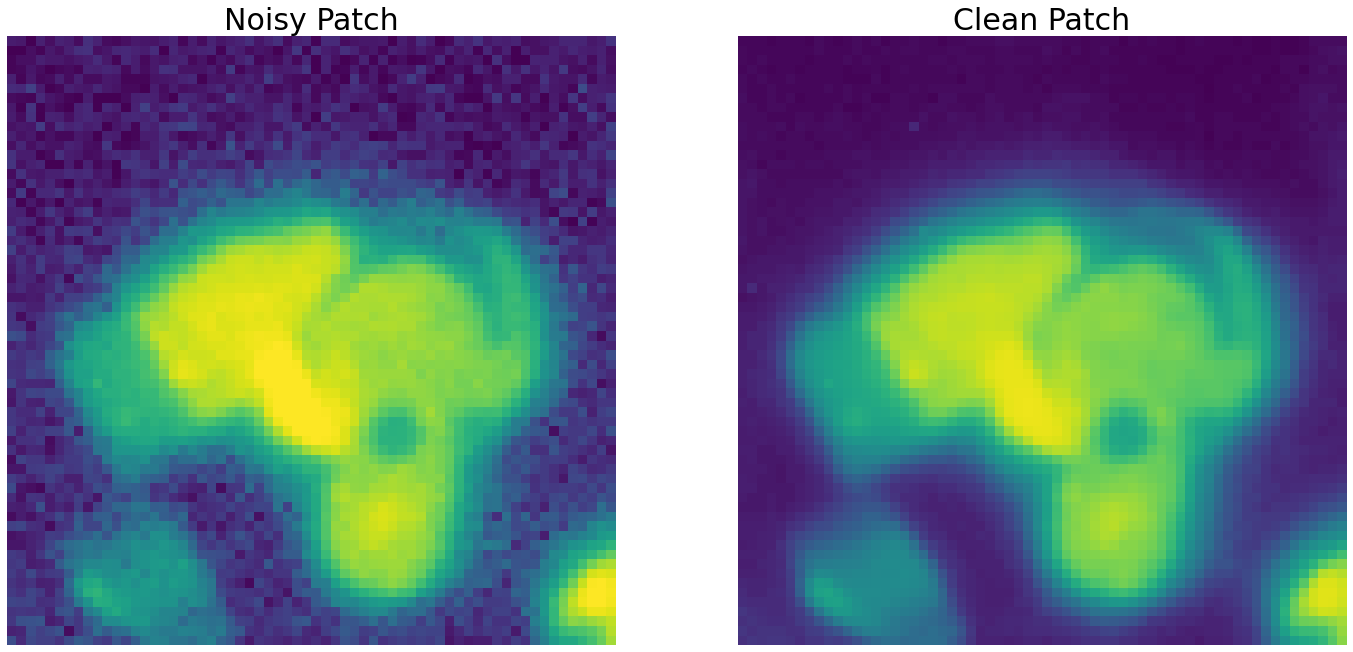

In [10]:
def display_training_pair(dataloader, sample_id):
    
    images, labels = next(iter(dataloader))    
    images = images.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    
    fig, ax = plt.subplots(1, 2, figsize=(24,20))
    vmin, vmax = np.percentile(images[sample_id][0], (1,99))


    ax[0].imshow(images[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].set_title('Noisy Patch', fontsize=30)
    ax[0].axis('off')
    ax[1].imshow(labels[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].set_title('Clean Patch', fontsize=30)
    ax[1].axis('off')
    
display_training_pair(dataloader=train_dataloader, sample_id=0)

# Implementing [this](https://github.com/bestaar/predictiveFilterFlow/blob/master/predictiveFilterFlow.ipynb) guys code

In [11]:
# predictive filter flow layer
# https://arxiv.org/abs/1811.11482
# Kong, S., & Fowlkes, C. (2018). Image reconstruction with predictive filter flow. arXiv preprint arXiv:1811.11482.
# - learn and apply individual filters (ksize x ksize) for each spatial position in the input
# - i.e. when using softmax activation it is basically image warping, but instead of offsets, we learn filters
class pFF(nn.Module):
    def __init__(self,ni, ksize=3,stride=1,softmax = True,upsample=1):
        super(pFF, self).__init__()
        # size of the learned filter: ksize x ksize
        self.ksize=ksize
        # use softmax or tanh
        self.softmax = softmax
        # upsampling of the learned filters (gives smoother result)
        self.upsample = upsample
        # train conv layer to output filter flow and use reflection padding
        self.get_filter = nn.Conv2d(ni,ksize**2,3,padding=1,stride=upsample,padding_mode='reflect')
        self.pad = nn.ReflectionPad2d(padding=int((ksize-1)/2)*stride)
        # apply learned filters
        self.uf1 = nn.Unfold(ksize, dilation=stride, padding=0, stride=1)
        self.uf2 = nn.Unfold(1, dilation=1, padding=0, stride=1)
        if upsample>1:
            self.us = nn.UpsamplingBilinear2d(scale_factor=upsample)
        
    def forward(self, features,inpt):
        # features: features learned by CNN, inpt: input that filters should be applied to
        # 1: get filter
        ff = self.get_filter(features)
        # 2: apply activation function
        if self.softmax:
            ff = F.softmax(ff,dim=1)
        else:
            ff = torch.tanh(ff)
        if self.upsample>1:
            ff = self.us(ff)
            
        # apply learned filters
        inp_pad = self.pad(inpt)
        
        # use filter on each channel/feature of the input
        ff = torch.cat([ff]*inpt.shape[1],dim=1)
        out = self.uf1(inp_pad) * self.uf2(ff)
        out = out.view(-1,inpt.shape[1],self.ksize**2,inpt.shape[2],inpt.shape[3])
        return out.sum(dim=2)

In [12]:
# Build U-Net for face2face translation usining predictive filter flow
# U-Net adapted from https://github.com/milesial/Pytorch-UNet
# - use residual blocks instead of double convolution
# - replaced transpose conv with PixelShuffle for efficiency
# - replaced conv2d with depthwise separable conv for efficiency
# - Use Mish activation function: code by https://github.com/lessw2020/mish
# - multiple residual blocks in the middle
# - predictive filter flow


class Mish(nn.Module):
    # source: https://github.com/lessw2020/mish
    def __init__(self):
        super().__init__()
    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))
    

class depthwise_separable_conv(nn.Module):
    # source: "shicai": https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843)
    def __init__(self, nin, nout,stride=1,ksize=3):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=ksize, padding=int((ksize-1)/2), groups=nin,stride=stride,padding_mode='reflect')
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class block1(nn.Module):
    def __init__(self,ni,no,stride=2,last_act=True):
        super(block1, self).__init__()
        self.bottleneck = ni != no
        self.last_act = last_act
        self.stride=stride
        self.sconv1 = depthwise_separable_conv(ni,no,stride)
        self.sconv2 = depthwise_separable_conv(no,no)
        self.sconv3 = depthwise_separable_conv(no,no)
        self.normact0 = nn.Sequential(nn.BatchNorm2d(no),Mish())
        self.normact1 = nn.Sequential(nn.BatchNorm2d(no),Mish())
        self.normact2 = nn.Sequential(nn.BatchNorm2d(no),Mish())
    def forward(self,x):
        if self.stride>1 or self.bottleneck:
            x = self.normact0(self.sconv1(x))
        residual = x
        out = self.normact1(self.sconv2(x))
        out = self.sconv3(out)
        out += residual
        if self.last_act:
            out = self.normact2(out)
        return out


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = nn.Sequential(
            depthwise_separable_conv(in_ch, out_ch,1,7),
            Mish()
        )
    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv = block1(in_ch,out_ch,2)
    def forward(self, x):
        x = self.conv(x)
        return x

    
class res_block(nn.Module):
    def __init__(self, in_ch):
        super(res_block, self).__init__()
        self.resconv = nn.Sequential(
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False),
            block1(in_ch,in_ch,1,False)
        )
    def forward(self, x):
        x = self.resconv(x)
        return x
    

class up(nn.Module):
    def __init__(self, in_ch,mid_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        # theoretically it makes sense to add another conv layer before pixel
        # shuffle since we need a positional encoding, but here I did not find
        # it to be necessary
#         self.conv1 = nn.Conv2d(in_ch, in_ch, kernel_size=1)
        self.ups = nn.modules.PixelShuffle(2)
        self.norm = nn.BatchNorm2d(in_ch//4+mid_ch)
        self.conv2 = block1(in_ch//4+mid_ch, out_ch,1)
    def forward(self, x1, x2):
        # double spatial resolution via pixel shuffle
#         x1 = self.conv1(x1) 
        x1 = self.ups(x1)
        # combine information of high- and low-level features
        x = torch.cat([x2, x1], dim=1)
        x = self.norm(x)
        x = self.conv2(x)
        return x  
    
    

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128,256)
        self.down4 = down(256,256)
        self.res1 = res_block(256)
        
        self.up1 = up(256,256, 256)
        self.up2 = up(256,128, 128)
        self.up3 = up(128,64,64)
        self.up4 = up(64,64, 64)
        
        self.filter0 = pFF(64, ksize=9)
        self.filter1 = pFF(64, ksize=9,stride=4)
        self.filter2 = pFF(64, ksize=9,stride=8)
        self.filter3 = pFF(64, ksize=9)
        
    def forward(self, inp):
        x1 = self.inc(inp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.res1(x5)
        
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        filtered = self.filter0(x,inp)
        filtered = self.filter1(x,filtered)
        filtered = self.filter2(x,filtered)
        filtered = self.filter3(x,filtered)
    
        return filtered#torch.sigmoid(x)*4-1.6 #x

model = UNet()
model = model.to(device)
# summary(model, input_size=(3, size,size))

In [13]:
def charbonnier(y_pred, y_true):
    epsilon = 1e-3
    error = y_true - y_pred
    p = torch.sqrt(error**2 + epsilon**2)
    return torch.mean(p)


# Perceptual Loss:
# original code from: fast.ai lesson ???
# modifications:
# - Instance Normalization of low-level features to remove influence of "style"
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)
vgg_m = vgg16_bn(True).features.cuda().eval()

vgg_m.requires_grad_(False)
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]

# requires_grad(vgg_m, False)
# blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

base_loss = F.mse_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts,without_instancenorm=1):
        super().__init__()
        self.m_feat = m_feat
        # how many layers are not subjected to instance norm (starting from high-level, i.e. later layers)
        self.without_instancenorm = without_instancenorm
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook.hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))
                                         ]+ [f'gram_{i}' for i in range(len(layer_ids))]
              

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        try:
            # instance normalization for all but last layer
            for l in range(len(in_feat)-self.without_instancenorm):
                in_feat[l] = nn.InstanceNorm2d(in_feat[l][1],momentum=0)(in_feat[l])
                out_feat[l] = nn.InstanceNorm2d(out_feat[l][1],momentum=0)(out_feat[l])
                
            self.feat_losses = [base_loss(f_in, f_out)*w
                                 for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
            self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                                 for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        except IndexError: # No idea why this tends to happen (only during validation)
            self.feat_losses = [torch.tensor(1).float().to(device)]
            for k in range(6):
                self.feat_losses += [torch.tensor(1).float().to(device)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
        
        
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [2,2,3])

In [14]:
dls = DataLoaders.from_dsets(train_ds, test_ds)
dls.show_batch()

NameError: name 'DataLoaders' is not defined

In [ ]:
from fastai.data.core import DataLoaders
# dls = DataLoaders(train_dataloader)

dl_noise = DataLoader(train_data[0])
dl_clean = DataLoader(train_data[1])

dls = DataLoaders(dl_noise, dl_clean)

In [ ]:
len(dls)

In [ ]:
G = Learner(dls,model,loss_func=feat_loss, opt_func=Ranger)
gc.collect()

G.show_results(rows=2, imgsize=5)

In [ ]:
# G = Learner(test_dataloader,model,loss_func=feat_loss, opt_func=Ranger)
G = Learner(train_data,model,loss_func=feat_loss, opt_func=Ranger)
gc.collect()

G.show_results(rows=2, imgsize=5)

In [ ]:
np.allclose(G.dls, train_data)

In [ ]:
Learner??

In [ ]:
# path_inp = 'data/A2JackieChan'


path_inp = 'pscratch/sd/m/mdowicz/DESI_dn/Data/training_data610-2000.npy'
src = ImageImageList.from_folder(path_inp).split_by_rand_pct(0.05, seed=42)


In [ ]:
def get_data(bs,size):
    data = (torch.from_numpy(train_data)
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data
data = get_data(bs,size)
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))
data

In [ ]:
# G = Learner(test_dataloader,model,loss_func=feat_loss, opt_func=Ranger)
G = Learner(train_data,model,loss_func=feat_loss, opt_func=Ranger)

gc.collect()
# show output before training


G.show_results(rows=2, imgsize=5)

In [ ]:
train_ds